<a href="https://colab.research.google.com/github/gladysadyaz/Hybrid-VAR-LSTM/blob/main/Evaluation_of_Hybrid_Tourist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import warnings
import itertools
import statsmodels.api as sm
import tensorflow.keras as keras
import seaborn as sns
import tensorflow as tf
import gc

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from numpy import array

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.options.display.float_format = '{:.2f}'.format

# MODELING

# B. LONG SHORT TERM MEMORY

## Splitting & Scaling

In [ ]:
file_path_actual = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df_actual = pd.read_excel(file_path_actual, sheet_name='Sheet1')
df_actual['Date'] = pd.to_datetime(df_actual['Date'], format='%d/%m/%Y')
df_actual.set_index('Date', inplace=True)
print(df_actual.head())

             Kurs  Wisman Bali  Hari Raya
Date                                     
2023-01-01  15592        10626          1
2023-01-02  15572        12338          1
2023-01-03  15590        12122          1
2023-01-04  15615        11957          1
2023-01-05  15610        13463          1


In [ ]:
file_path = "/content/drive/My Drive/Colab Notebooks/varx_residuals.xlsx"
df = pd.read_excel(file_path, sheet_name='FIXVAR')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

             Kurs  Wisman Bali
Date                          
2023-01-02 -19.95         1700
2023-01-03   2.17         2052
2023-01-04  22.77         2008
2023-01-05  18.88         3759
2023-01-06  43.49         3592


In [ ]:
steps_slicing = 90
df_final = df_actual[:-steps_slicing]
df_update = df_actual[-steps_slicing:]

In [ ]:
# Select only the 'Wisman Bali' column for input and output
df_residual = df['Wisman Bali']
data2 = df_residual.copy()
data2

,Wisman Bali
Date,
2023-01-02,1700
2023-01-03,2052
2023-01-04,2008
2023-01-05,3759
2023-01-06,3592
...,...
2025-01-16,-2399
2025-01-17,-1242
2025-01-18,-1792


In [ ]:
scaler2 = MinMaxScaler()
scaled_data2 = scaler2.fit_transform(data2.values.reshape(-1, 1))

In [ ]:
# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]  # Use only the first column
        dataX.append(a)
        dataY.append(data[i + time_step, 0])  # Use only the first column
    return np.array(dataX), np.array(dataY)

In [ ]:
# Set the time step
time_step = 15

# Create the dataset for LSTM
X2, y2 = create_dataset(scaled_data2, time_step)

# Reshape X2 to be [samples, time steps, features] which is required for LSTM
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)

In [ ]:
test_size2 = 90
train_size2 = len(X2) - test_size2
X2_train, X2_test = X2[:train_size2], X2[train_size2:]
y2_train, y2_test = y2[:train_size2], y2[train_size2:]

## Hypertuning Parameters

In [ ]:
# Function to create model for LSTM
def create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme):
    seed_value = 54
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(time_step, 1), kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(units=units2, kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='linear', kernel_initializer=init_scheme))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [ ]:
# Define the hyperparameter grid for LSTM
param_grid_lstm2 = {
    'units1': [50,100],
    'units2': [50,100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.01,0.001],
    'batch_size': [16,32],
    'epochs': [100],
    'init_scheme': ['he_uniform', 'glorot_uniform']
}

In [ ]:
from itertools import product
# Convert param_grid to a list of dictionaries
param_list_lstm2 = list(product(param_grid_lstm2['units1'],
                                param_grid_lstm2['units2'],
                                param_grid_lstm2['dropout_rate'],
                                param_grid_lstm2['learning_rate'],
                                param_grid_lstm2['batch_size'],
                                param_grid_lstm2['epochs'],
                                param_grid_lstm2['init_scheme'],))

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# Fungsi SMAPE
def smape(A, F):
    A, F = np.array(A), np.array(F)
    return np.mean(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))) * 100

# Inisialisasi variabel untuk tracking model terbaik
best_score_lstm2 = float('inf')
best_params_lstm2 = None
best_model_lstm2 = None

# Ukuran train-test dan shifting antar window
train_sz = 90
test_sz = 30
shift = 87

# Loop untuk grid search dengan parameter dari param_list_lstm2
for params in tqdm(param_list_lstm2):
    val_smape_scores = []
    units1, units2, dropout_rate, learning_rate, batch_size, epochs, init_scheme = params

    for i in range(8):
        idx_train = train_sz + shift * i
        idx_test = train_sz + test_sz + shift * i

        # Split data
        X2_train, X2_test = X2[:idx_train], X2[idx_train:idx_test]
        y2_train, y2_test = y2[:idx_train], y2[idx_train:idx_test]

        # Buat model LSTM2
        model_lstm2 = create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme)

        # Callback early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Training
        model_lstm2.fit(
            X2_train, y2_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X2_test, y2_test),
            callbacks=[early_stopping],
            verbose=0
        )

        # Prediksi dan inverse transform
        y2_test_pred = model_lstm2.predict(X2_test)
        y2_test_pred_denorm = scaler2.inverse_transform(y2_test_pred).flatten()
        y2_test_denorm = scaler2.inverse_transform(y2_test.reshape(-1, 1)).flatten()

        # Hitung SMAPE
        smape_score = smape(y2_test_denorm, y2_test_pred_denorm)
        val_smape_scores.append(smape_score)

        print(f"SMAPE window {i+1}: {smape_score:.4f}")

    # Hitung rata-rata SMAPE dari 8 window
    smape_avg = np.mean(val_smape_scores)

    # Simpan jika ini model terbaik sejauh ini
    if smape_avg < best_score_lstm2:
        best_score_lstm2 = smape_avg
        best_params_lstm2 = {
            'units1': units1,
            'units2': units2,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'init_scheme': init_scheme
        }
        best_model_lstm2 = model_lstm2

# Print hasil akhir
print(f"Best LSTM2 average SMAPE: {best_score_lstm2:.2f}%")
print(f"Best parameters: {best_params_lstm2}")


  0%|          | 0/64 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 1: 39.4621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
SMAPE window 2: 43.6072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
SMAPE window 3: 56.5520
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 4: 152.8669
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 5: 13.4031
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 6: 4.0678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 7: 16.2021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


  2%|▏         | 1/64 [01:00<1:03:41, 60.66s/it]

SMAPE window 8: 114.8142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
SMAPE window 1: 32.7502
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
SMAPE window 2: 9.2624
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
SMAPE window 3: 59.2900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 4: 63.7978
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 5: 10.8912
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 6: 6.2463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 7: 17.7843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


  3%|▎         | 2/64 [02:04<1:04:38, 62.55s/it]

SMAPE window 8: 103.3850
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 1: 35.0686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
SMAPE window 2: 29.2755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 3: 78.0300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 4: 100.9966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 5: 12.6359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
SMAPE window 6: 15.5197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 7: 14.2097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


  5%|▍         | 3/64 [02:57<59:03, 58.09s/it]  

SMAPE window 8: 104.8275
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 1: 35.0510
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 2: 16.1888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 3: 68.2891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
SMAPE window 4: 151.4287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 5: 19.3122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
SMAPE window 6: 5.2802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
SMAPE window 7: 18.3282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  6%|▋         | 4/64 [03:47<54:56, 54.95s/it]

SMAPE window 8: 103.6955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 1: 38.9781
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 2: 4.0053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
SMAPE window 3: 69.8510
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 4: 168.1806
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 5: 16.9610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 6: 5.5584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 7: 15.1548
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


  8%|▊         | 5/64 [04:50<56:48, 57.76s/it]

SMAPE window 8: 104.8291
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 1: 43.1213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 2: 3.8305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 3: 62.5941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
SMAPE window 4: 99.5916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 5: 19.4283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 6: 6.2458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 7: 17.4493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  9%|▉         | 6/64 [06:00<59:52, 61.94s/it]

SMAPE window 8: 101.5600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 1: 44.5884
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 2: 14.0108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 3: 60.6855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 4: 138.9632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 5: 21.4746
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
SMAPE window 6: 5.2152
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 7: 32.3498
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 11%|█         | 7/64 [06:56<57:02, 60.05s/it]

SMAPE window 8: 101.4683
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 1: 48.0620
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 2: 3.7006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 3: 69.7339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 4: 94.1284
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
SMAPE window 5: 22.8940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 6: 10.8084
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 7: 23.4656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 12%|█▎        | 8/64 [07:45<52:41, 56.46s/it]

SMAPE window 8: 132.7793
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 1: 35.3856
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 2: 56.5371
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
SMAPE window 3: 55.2068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
SMAPE window 4: 165.2157
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
SMAPE window 5: 9.7440
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
SMAPE window 6: 4.4165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 7: 14.9181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 14%|█▍        | 9/64 [08:53<55:01, 60.03s/it]

SMAPE window 8: 97.8318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
SMAPE window 1: 30.4463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 2: 35.5565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 3: 60.8277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 4: 161.2262
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
SMAPE window 5: 13.4518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 6: 10.1663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 7: 16.8322
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 16%|█▌        | 10/64 [09:54<54:32, 60.61s/it]

SMAPE window 8: 105.4871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
SMAPE window 1: 36.5983
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 2: 41.6161
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 3: 73.2419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 4: 163.8632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 5: 18.4797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
SMAPE window 6: 22.2422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
SMAPE window 7: 15.1659
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 17%|█▋        | 11/64 [10:49<52:00, 58.88s/it]

SMAPE window 8: 110.4948
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 1: 32.2120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 2: 12.7733
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 3: 75.3855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 4: 158.4658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 5: 17.0352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 6: 5.6367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 7: 17.7990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 19%|█▉        | 12/64 [11:42<49:18, 56.89s/it]

SMAPE window 8: 99.7920
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
SMAPE window 1: 41.8443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 2: 4.0725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 3: 69.1407
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
SMAPE window 4: 120.5674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 5: 21.6191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 6: 5.4485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
SMAPE window 7: 52.8574
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 20%|██        | 13/64 [12:44<49:38, 58.41s/it]

SMAPE window 8: 144.9536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 1: 43.6404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
SMAPE window 2: 3.7408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
SMAPE window 3: 60.9399
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 4: 93.9078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 5: 20.8103
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
SMAPE window 6: 6.8774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 7: 17.5717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 22%|██▏       | 14/64 [13:45<49:28, 59.38s/it]

SMAPE window 8: 134.2785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 1: 44.5229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 2: 21.2355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 3: 66.7271
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 4: 152.5224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
SMAPE window 5: 17.2598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
SMAPE window 6: 5.3982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 7: 31.7156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 23%|██▎       | 15/64 [14:45<48:38, 59.56s/it]

SMAPE window 8: 144.1173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
SMAPE window 1: 49.7351
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 2: 3.8683
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 3: 72.7301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 4: 87.4727
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 5: 24.2946
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
SMAPE window 6: 11.2444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 7: 20.2479
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 25%|██▌       | 16/64 [15:36<45:30, 56.88s/it]

SMAPE window 8: 131.5931
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
SMAPE window 1: 38.5390
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 2: 22.0285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 3: 53.1906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 4: 163.5722
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
SMAPE window 5: 13.3006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
SMAPE window 6: 4.6033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 7: 13.9264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 27%|██▋       | 17/64 [16:45<47:28, 60.62s/it]

SMAPE window 8: 104.6473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 1: 34.8596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 2: 3.8316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
SMAPE window 3: 70.4444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 4: 117.0423
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
SMAPE window 5: 11.2366
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
SMAPE window 6: 7.5544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 7: 16.8440
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 28%|██▊       | 18/64 [17:57<48:56, 63.84s/it]

SMAPE window 8: 97.7616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
SMAPE window 1: 43.1261
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
SMAPE window 2: 13.7891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 3: 76.9479
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
SMAPE window 4: 162.0065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 5: 13.7635
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 6: 38.8811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 7: 23.2359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 30%|██▉       | 19/64 [18:52<46:04, 61.43s/it]

SMAPE window 8: 104.9475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 1: 54.6121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 2: 9.8621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 3: 58.8721
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 4: 68.2004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 5: 13.4442
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
SMAPE window 6: 13.1712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 7: 15.9723
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 31%|███▏      | 20/64 [19:50<44:14, 60.33s/it]

SMAPE window 8: 95.2609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
SMAPE window 1: 43.9053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 2: 3.5618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
SMAPE window 3: 63.9852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 4: 86.5227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
SMAPE window 5: 13.8722
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 6: 6.8889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 7: 16.7068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 33%|███▎      | 21/64 [20:57<44:33, 62.16s/it]

SMAPE window 8: 98.2514
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 1: 45.3094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 2: 3.9148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 3: 95.5838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 4: 103.6770
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 5: 20.4050
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 6: 6.2255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 7: 21.6545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 34%|███▍      | 22/64 [22:13<46:33, 66.50s/it]

SMAPE window 8: 100.5489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
SMAPE window 1: 43.4855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
SMAPE window 2: 27.0118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
SMAPE window 3: 71.5937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 4: 120.2346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
SMAPE window 5: 17.4479
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 6: 4.6464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 7: 32.8176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 36%|███▌      | 23/64 [23:11<43:40, 63.91s/it]

SMAPE window 8: 98.4399
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 1: 46.0187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 2: 3.7609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
SMAPE window 3: 94.9233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 4: 113.7570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 5: 23.6502
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 6: 10.4826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 7: 21.3103
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 38%|███▊      | 24/64 [24:00<39:35, 59.39s/it]

SMAPE window 8: 132.3298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 1: 38.6433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 2: 30.2261
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 3: 52.3305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 4: 162.5885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 5: 14.1030
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
SMAPE window 6: 4.5112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 7: 18.2399
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 39%|███▉      | 25/64 [25:06<39:49, 61.27s/it]

SMAPE window 8: 109.5184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 1: 37.5434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
SMAPE window 2: 9.1494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
SMAPE window 3: 56.6717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
SMAPE window 4: 75.6622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 5: 9.5850
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
SMAPE window 6: 6.0493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 7: 24.6295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 41%|████      | 26/64 [26:13<39:59, 63.15s/it]

SMAPE window 8: 97.7189
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 1: 36.8469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 2: 23.7084
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 3: 76.7060
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 4: 161.9319
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 5: 18.6330
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 6: 32.8897
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 7: 27.9429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 42%|████▏     | 27/64 [27:14<38:35, 62.57s/it]

SMAPE window 8: 101.6062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
SMAPE window 1: 33.6026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
SMAPE window 2: 10.0048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 3: 60.7955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 4: 70.2641
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
SMAPE window 5: 17.8182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
SMAPE window 6: 12.5709
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
SMAPE window 7: 25.3640
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 44%|████▍     | 28/64 [28:08<35:53, 59.83s/it]

SMAPE window 8: 98.3631
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 1: 45.9648
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
SMAPE window 2: 10.4551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
SMAPE window 3: 79.2307
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 4: 170.7677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 5: 15.8947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 6: 4.8256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 7: 31.6877
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 45%|████▌     | 29/64 [29:07<34:49, 59.71s/it]

SMAPE window 8: 105.5634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
SMAPE window 1: 42.5725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 2: 4.2069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
SMAPE window 3: 96.0624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 4: 107.1794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 5: 20.8613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 6: 6.2861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 7: 22.0770
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 47%|████▋     | 30/64 [30:14<35:02, 61.84s/it]

SMAPE window 8: 108.2534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 1: 53.1690
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
SMAPE window 2: 6.2058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
SMAPE window 3: 73.8027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 4: 164.2938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 5: 18.4651
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
SMAPE window 6: 4.9788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 7: 42.6778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 48%|████▊     | 31/64 [31:08<32:39, 59.37s/it]

SMAPE window 8: 113.0057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 1: 46.4455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 2: 4.6847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 3: 62.7683
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 4: 110.3341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
SMAPE window 5: 23.2083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 6: 13.2153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 7: 21.0478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 50%|█████     | 32/64 [31:57<30:00, 56.27s/it]

SMAPE window 8: 133.6382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 1: 35.7475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 2: 42.4519
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 3: 66.2973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
SMAPE window 4: 60.3351
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
SMAPE window 5: 11.3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 6: 4.0551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
SMAPE window 7: 23.1571
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 52%|█████▏    | 33/64 [33:15<32:28, 62.85s/it]

SMAPE window 8: 105.5142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
SMAPE window 1: 34.0906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
SMAPE window 2: 4.3649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 3: 70.9987
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
SMAPE window 4: 68.3033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 5: 10.0794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
SMAPE window 6: 6.2789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
SMAPE window 7: 15.5853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 53%|█████▎    | 34/64 [34:39<34:37, 69.26s/it]

SMAPE window 8: 99.8084
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
SMAPE window 1: 42.0735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
SMAPE window 2: 44.6842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 3: 69.1348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 4: 161.6093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 5: 17.4677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
SMAPE window 6: 4.2536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
SMAPE window 7: 15.6940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 55%|█████▍    | 35/64 [35:35<31:35, 65.38s/it]

SMAPE window 8: 100.7339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 1: 34.1482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 2: 22.4570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 3: 63.6234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 4: 155.0661
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 5: 13.9452
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 6: 5.0952
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
SMAPE window 7: 18.4215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 56%|█████▋    | 36/64 [36:33<29:25, 63.06s/it]

SMAPE window 8: 106.0563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 1: 38.0875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 2: 3.3709
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 3: 63.3075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 4: 84.8971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 5: 13.8207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
SMAPE window 6: 4.4108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 7: 20.2775
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 58%|█████▊    | 37/64 [37:36<28:24, 63.14s/it]

SMAPE window 8: 102.9296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 1: 42.4439
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
SMAPE window 2: 3.7708
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 3: 92.6633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 4: 103.0583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 5: 20.2804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 6: 7.0681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 7: 17.6561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 59%|█████▉    | 38/64 [38:44<27:56, 64.50s/it]

SMAPE window 8: 106.3109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
SMAPE window 1: 55.5522
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 2: 5.0277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 3: 70.2450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 4: 149.2494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
SMAPE window 5: 15.0127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 6: 4.4151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 7: 16.1942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 61%|██████    | 39/64 [39:43<26:13, 62.92s/it]

SMAPE window 8: 103.2269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 1: 46.5438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 2: 4.8070
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 3: 95.9056
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
SMAPE window 4: 105.8363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 5: 22.6158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 6: 13.3360
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
SMAPE window 7: 21.4859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 62%|██████▎   | 40/64 [40:43<24:46, 61.94s/it]

SMAPE window 8: 133.8185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 1: 36.7900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 2: 33.5781
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
SMAPE window 3: 52.9381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 4: 47.4863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 5: 10.6746
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 6: 4.2448
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
SMAPE window 7: 13.9651
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 64%|██████▍   | 41/64 [41:53<24:43, 64.52s/it]

SMAPE window 8: 97.2201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 1: 34.5464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 2: 5.8666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
SMAPE window 3: 75.2575
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 4: 156.8332
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 5: 16.0076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 6: 5.7854
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 7: 16.4606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 66%|██████▌   | 42/64 [42:58<23:41, 64.61s/it]

SMAPE window 8: 97.2666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
SMAPE window 1: 36.8533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 2: 52.2431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 3: 77.1899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 4: 162.1124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 5: 12.3313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 6: 38.5601
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
SMAPE window 7: 13.8239
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 67%|██████▋   | 43/64 [43:54<21:41, 61.97s/it]

SMAPE window 8: 102.6984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 1: 37.0322
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
SMAPE window 2: 26.9497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 3: 63.8293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 4: 155.3310
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
SMAPE window 5: 8.5376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 6: 5.8779
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 7: 16.9653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 69%|██████▉   | 44/64 [45:01<21:05, 63.30s/it]

SMAPE window 8: 96.8468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 1: 34.3326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 2: 16.1062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 3: 62.2014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 4: 161.9588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 5: 16.5117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
SMAPE window 6: 4.2822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 7: 21.0440
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 70%|███████   | 45/64 [46:00<19:40, 62.11s/it]

SMAPE window 8: 105.9463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 1: 42.2813
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 2: 3.9195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 3: 61.5126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 4: 97.1724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
SMAPE window 5: 20.2699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 6: 7.3580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 7: 16.6181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 72%|███████▏  | 46/64 [47:18<20:04, 66.93s/it]

SMAPE window 8: 100.6650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 1: 38.2565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
SMAPE window 2: 9.3031
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 3: 76.7702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 4: 81.2996
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
SMAPE window 5: 16.6482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 6: 4.5325
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 7: 30.6904
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 73%|███████▎  | 47/64 [48:10<17:42, 62.50s/it]

SMAPE window 8: 113.2265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 1: 46.5553
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 2: 3.7033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 3: 96.3152
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 4: 103.7699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 5: 20.9095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 6: 6.1580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 7: 21.5959
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 75%|███████▌  | 48/64 [49:15<16:48, 63.04s/it]

SMAPE window 8: 134.1768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
SMAPE window 1: 36.9179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
SMAPE window 2: 68.3136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
SMAPE window 3: 63.9477
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
SMAPE window 4: 117.8685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
SMAPE window 5: 12.1778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
SMAPE window 6: 3.6983
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 7: 14.2670
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 77%|███████▋  | 49/64 [50:29<16:35, 66.34s/it]

SMAPE window 8: 96.3840
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
SMAPE window 1: 34.2371
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 2: 57.3610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 3: 60.4579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 4: 164.8969
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 5: 9.7049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 6: 5.1306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 7: 16.6798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 78%|███████▊  | 50/64 [51:32<15:17, 65.55s/it]

SMAPE window 8: 109.9554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
SMAPE window 1: 36.1829
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 2: 25.7865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 3: 51.7558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 4: 164.4636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
SMAPE window 5: 9.9529
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 6: 3.4391
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
SMAPE window 7: 18.0376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 80%|███████▉  | 51/64 [52:40<14:20, 66.21s/it]

SMAPE window 8: 95.8303
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
SMAPE window 1: 41.8547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 2: 6.7258
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 3: 66.6604
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
SMAPE window 4: 148.7727
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
SMAPE window 5: 19.0917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 6: 5.8448
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 7: 17.4844
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 81%|████████▏ | 52/64 [53:35<12:35, 62.94s/it]

SMAPE window 8: 96.6235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
SMAPE window 1: 30.9980
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 2: 3.5806
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 3: 64.6848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 4: 130.2540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 5: 14.7488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
SMAPE window 6: 4.7562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
SMAPE window 7: 17.4734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 83%|████████▎ | 53/64 [54:35<11:22, 62.05s/it]

SMAPE window 8: 96.8408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
SMAPE window 1: 40.5326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 2: 3.6294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 3: 59.6748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 4: 165.8830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 5: 17.7776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 6: 6.0374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 7: 21.7728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 84%|████████▍ | 54/64 [55:49<10:56, 65.63s/it]

SMAPE window 8: 99.1780
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 1: 44.2645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 2: 11.1463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 3: 68.3064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 4: 147.5276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 5: 13.5771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 6: 4.7491
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
SMAPE window 7: 16.3569
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 86%|████████▌ | 55/64 [56:45<09:24, 62.77s/it]

SMAPE window 8: 99.3433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 1: 50.6913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
SMAPE window 2: 3.5713
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
SMAPE window 3: 59.1290
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
SMAPE window 4: 164.1510
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 5: 23.3364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 6: 5.6091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 7: 21.3682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 88%|████████▊ | 56/64 [57:51<08:28, 63.57s/it]

SMAPE window 8: 104.5215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
SMAPE window 1: 34.5869
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 2: 42.3229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 3: 65.7654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 4: 149.3676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 5: 8.6721
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 6: 4.7147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 7: 13.9859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 89%|████████▉ | 57/64 [59:05<07:46, 66.65s/it]

SMAPE window 8: 94.3624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
SMAPE window 1: 33.7482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 2: 6.1287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
SMAPE window 3: 73.3600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 4: 170.2889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 5: 17.2717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
SMAPE window 6: 6.4316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
SMAPE window 7: 15.9903
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 91%|█████████ | 58/64 [1:00:26<07:06, 71.04s/it]

SMAPE window 8: 101.1763
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
SMAPE window 1: 35.7977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
SMAPE window 2: 32.7714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
SMAPE window 3: 74.5847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
SMAPE window 4: 163.7738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 5: 16.3779
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
SMAPE window 6: 36.6352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
SMAPE window 7: 18.3229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 92%|█████████▏| 59/64 [1:01:24<05:35, 67.07s/it]

SMAPE window 8: 96.5218
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
SMAPE window 1: 36.1020
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
SMAPE window 2: 6.5595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
SMAPE window 3: 60.6169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
SMAPE window 4: 163.2809
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 5: 10.9058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 6: 5.0771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 7: 16.3816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 94%|█████████▍| 60/64 [1:02:31<04:28, 67.16s/it]

SMAPE window 8: 97.7824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 1: 32.9018
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
SMAPE window 2: 4.2347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 3: 81.1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
SMAPE window 4: 168.7420
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
SMAPE window 5: 16.9196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 6: 4.6136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
SMAPE window 7: 15.8972
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 95%|█████████▌| 61/64 [1:03:25<03:09, 63.04s/it]

SMAPE window 8: 112.5041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
SMAPE window 1: 40.7129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 2: 3.7800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 3: 59.4430
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 4: 167.2745
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
SMAPE window 5: 18.6171
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
SMAPE window 6: 5.6871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 7: 18.5454
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 97%|█████████▋| 62/64 [1:04:42<02:14, 67.47s/it]

SMAPE window 8: 107.6275
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
SMAPE window 1: 31.9649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
SMAPE window 2: 3.4873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
SMAPE window 3: 53.5879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
SMAPE window 4: 95.4129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
SMAPE window 5: 17.5410
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 6: 5.0309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
SMAPE window 7: 30.1598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 98%|█████████▊| 63/64 [1:05:34<01:02, 62.63s/it]

SMAPE window 8: 112.3506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
SMAPE window 1: 42.0088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
SMAPE window 2: 3.6847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
SMAPE window 3: 59.1679
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
SMAPE window 4: 167.8828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
SMAPE window 5: 22.1683
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
SMAPE window 6: 6.4521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
SMAPE window 7: 22.6706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


100%|██████████| 64/64 [1:06:36<00:00, 62.44s/it]

SMAPE window 8: 112.1103
Best LSTM2 average SMAPE: 37.11%
Best parameters: {'units1': 100, 'units2': 50, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100, 'init_scheme': 'he_uniform'}


## Model

In [ ]:
best_params_lstm2

{'units1': 100,
 'units2': 50,
 'dropout_rate': 0.3,
 'learning_rate': 0.01,
 'batch_size': 16,
 'epochs': 100,
 'init_scheme': 'he_uniform'}

In [ ]:
# Re-split data untuk pelatihan akhir model (bukan CV)
test_size2 = 90
train_size2 = len(X2) - test_size2

X2_train = X2[:train_size2]
X2_test = X2[train_size2:]
y2_train = y2[:train_size2]
y2_test = y2[train_size2:]

# Ambil parameter terbaik dari hasil grid search
manual_units1_lstm2 = best_params_lstm2['units1']
manual_units2_lstm2 = best_params_lstm2['units2']
manual_dropout_rate_lstm2 = best_params_lstm2['dropout_rate']
manual_learning_rate_lstm2 = best_params_lstm2['learning_rate']
manual_batch_size_lstm2 = best_params_lstm2['batch_size']
manual_epochs_lstm2 = best_params_lstm2['epochs']
manual_init_scheme_lstm2 = best_params_lstm2['init_scheme']

# Buat model dengan parameter terbaik
model_manual_lstm2 = create_model_lstm2(manual_units1_lstm2,
                                        manual_units2_lstm2,
                                        manual_dropout_rate_lstm2,
                                        manual_learning_rate_lstm2,
                                        manual_init_scheme_lstm2)

# Early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

# Latih model dengan parameter terbaik
history_manual_lstm2 = model_manual_lstm2.fit(X2_train,
                                              y2_train,
                                              batch_size=manual_batch_size_lstm2,
                                              epochs=manual_epochs_lstm2,
                                              validation_data=(X2_test, y2_test),
                                              callbacks=[early_stopping],
                                              verbose=1)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.5719 - val_loss: 0.0442
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0372 - val_loss: 0.0094
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0204 - val_loss: 0.0029
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0180 - val_loss: 0.0031
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0159 - val_loss: 0.0045
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0160 - val_loss: 0.0036
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0108 - val_loss: 0.0047
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0094 - val_loss: 0.0049
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0103 - val_loss: 0.0034
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0075 - val_loss: 0.0029
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0070 - val_loss: 0.0030
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

In [ ]:
# Summary model
model_manual_lstm2.summary()

Model: "sequential_542"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1084 (LSTM)                │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1084 (Dropout)          │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1085 (LSTM)                │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1085 (Dropout)          │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_542 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)

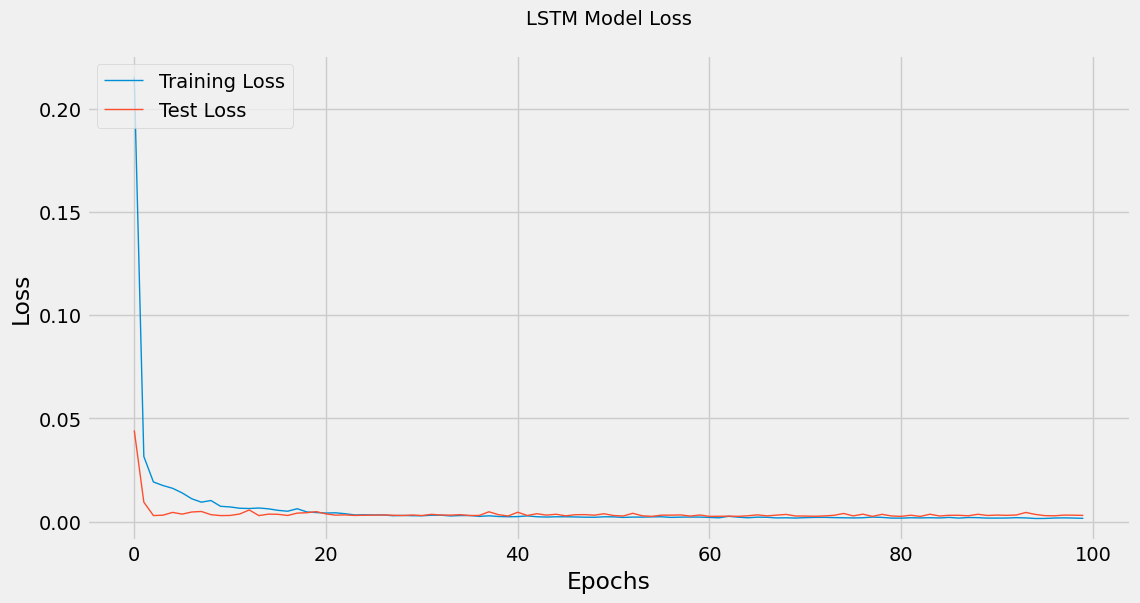

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(history_manual_lstm2.history['loss'], label='Training Loss', linewidth=1)
plt.plot(history_manual_lstm2.history['val_loss'], label='Test Loss', linewidth=1)
plt.title('LSTM Model Loss\n', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Predict on the training data for LSTM
train_predict_lstm2 = model_manual_lstm2.predict(X2_train)
test_predict_lstm2 = model_manual_lstm2.predict(X2_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
# Inverse transform the predictions for LSTM
train_predict_lstm2 = scaler2.inverse_transform(train_predict_lstm2)
test_predict_lstm2 = scaler2.inverse_transform(test_predict_lstm2)
y2_train = scaler2.inverse_transform(y2_train.reshape(-1, 1))
y2_test = scaler2.inverse_transform(y2_test.reshape(-1, 1))

## Evaluation & Visualization

In [ ]:
# Calculate MAPE for LSTM
train_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_train, train_predict_lstm2)
test_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_test, test_predict_lstm2)

print(f'Training MAPE (Wisman Bali) LSTM: {train_mape_kurs_lstm2:.4f}')
print(f'Testing MAPE (Wisman Bali) LSTM: {test_mape_kurs_lstm2:.4f}')


Training MAPE (Wisman Bali) LSTM: 0.4232
Testing MAPE (Wisman Bali) LSTM: 1.5742


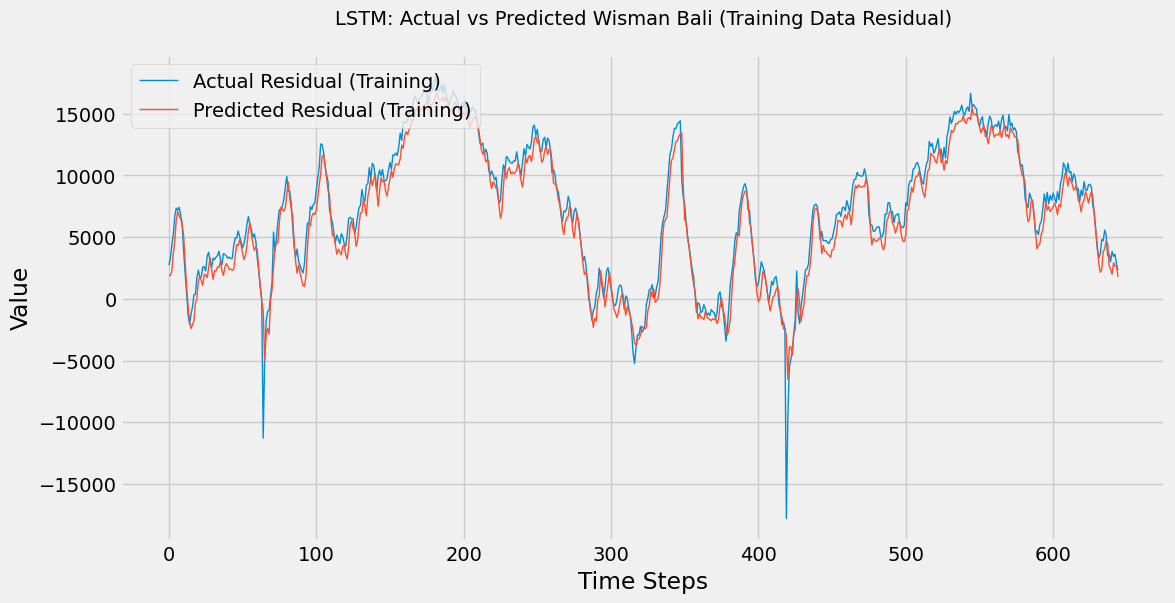

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_train, label='Actual Residual (Training)', linewidth=1)
plt.plot(train_predict_lstm2, label='Predicted Residual (Training)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Training Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

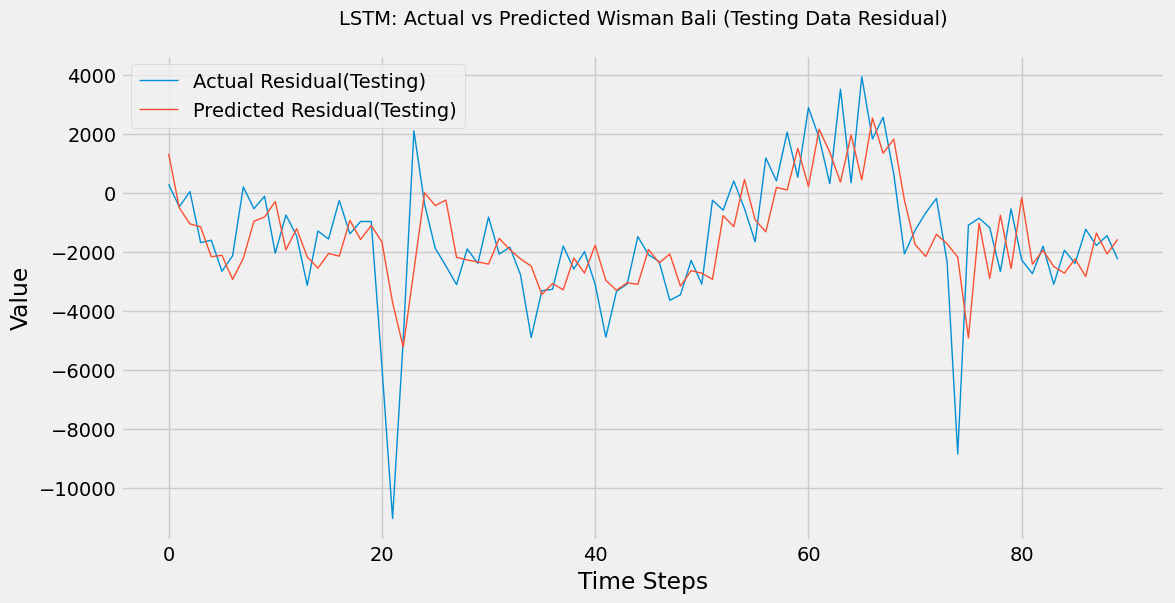

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_test, label='Actual Residual(Testing)', linewidth=1)
plt.plot(test_predict_lstm2, label='Predicted Residual(Testing)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Testing Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Biar aman, kita flatten dulu kalau masih 2D
actual = y2_test.flatten()
predicted = test_predict_lstm2.flatten()

start_date = pd.to_datetime('2024-10-23')
dates = pd.date_range(start=start_date, periods=90, freq='D')

df_result = pd.DataFrame({
    'Date': dates,
    'Actual Residual': actual,
    'Predicted Residual': predicted
})
df_result.set_index('Date', inplace=True)
print(df_result)

            Actual Residual  Predicted Residual
Date                                           
2024-10-23           283.00             1318.28
2024-10-24          -480.00             -515.50
2024-10-25            36.00            -1060.27
2024-10-26         -1694.00            -1161.86
2024-10-27         -1614.00            -2172.89
...                     ...                 ...
2025-01-16         -2399.00            -2247.94
2025-01-17         -1242.00            -2841.72
2025-01-18         -1792.00            -1368.98
2025-01-19         -1457.00            -2079.07
2025-01-20         -2259.00            -1582.96

[90 rows x 2 columns]


In [ ]:
df_nonlinear_test = (df_result[['Predicted Residual']])
df_nonlinear_test

,Predicted Residual
Date,
2024-10-23,1318.28
2024-10-24,-515.50
2024-10-25,-1060.27
2024-10-26,-1161.86
2024-10-27,-2172.89
...,...
2025-01-16,-2247.94
2025-01-17,-2841.72
2025-01-18,-1368.98


## Forecasting



In [ ]:
# Forecasting for the next 14 steps
predictions_lstm2 = []
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(14):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [ ]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Wisman Bali'])

# Assuming df_update is the dataframe where you want to align future predictions, here aligning index with the valid_data's last 7 steps.
dates = pd.date_range(start="2025-01-21", periods=14, freq='D')
df_future_predictions_lstm2.index = dates

# Display the future predictions DataFrame
df_future_predictions_lstm2

,Predicted Residual Wisman Bali
2025-01-21,-2558.80
2025-01-22,-2158.25
2025-01-23,-2644.51
2025-01-24,-2533.31
2025-01-25,-2721.21
2025-01-26,-2681.30
2025-01-27,-2726.21
2025-01-28,-2686.38
2025-01-29,-2631.57
2025-01-30,-2708.38


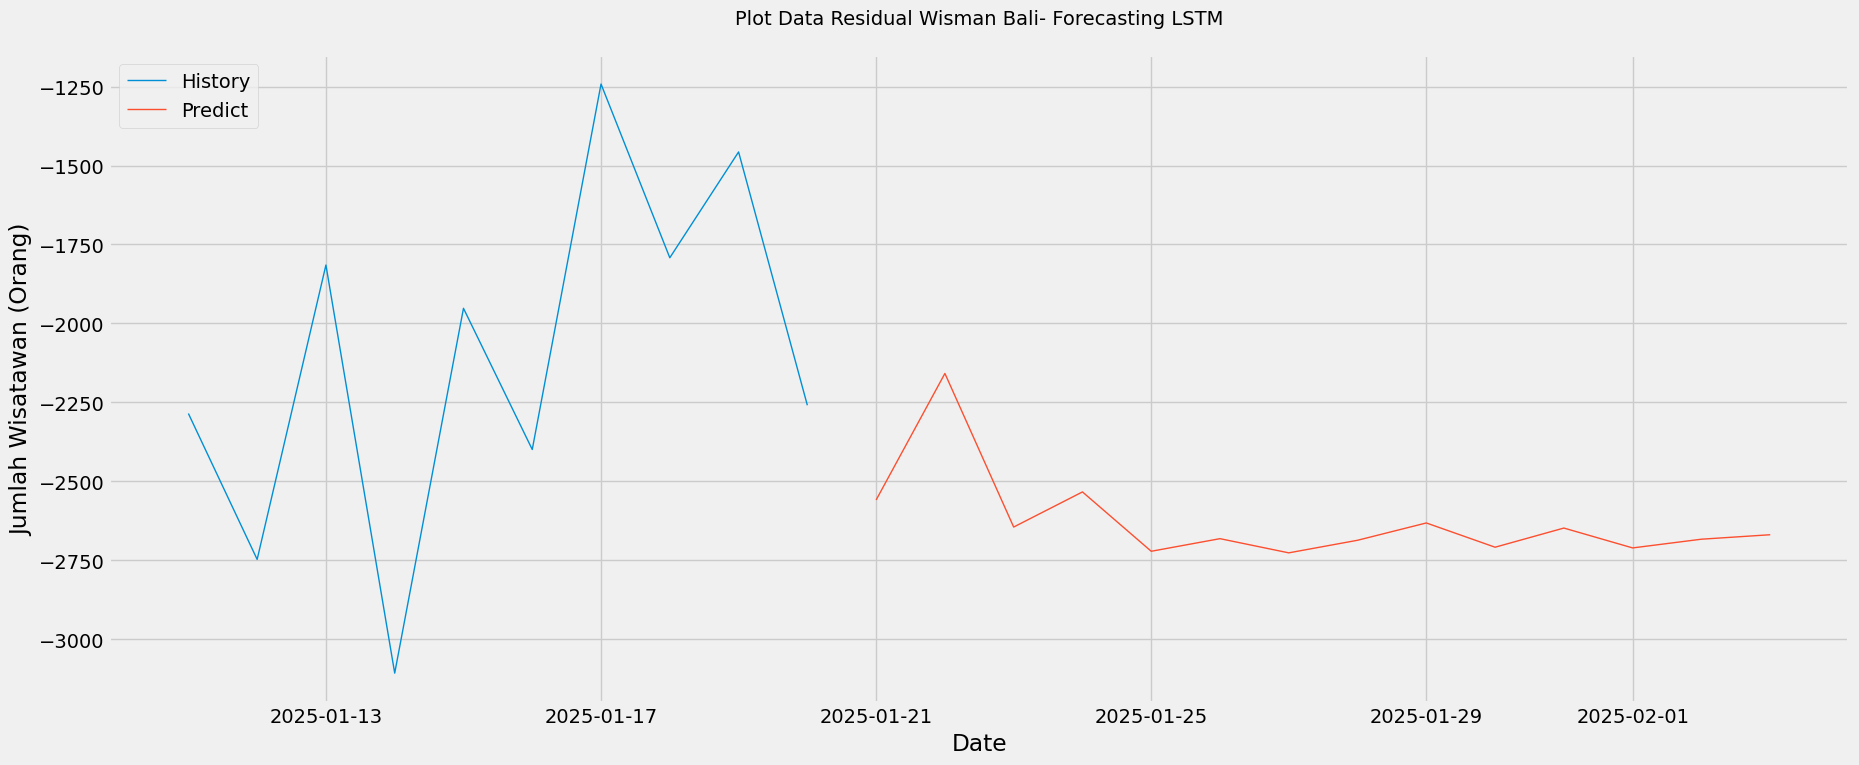

In [ ]:
# Plot Data
plt.figure(figsize=(20, 8))
plt.plot(df.iloc[-10:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_future_predictions_lstm2['Predicted Residual Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (Orang)')
plt.title('Plot Data Residual Wisman Bali- Forecasting LSTM\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# C. HYBRID VAR LSTM

## Model

In [ ]:
file_path_forecast = "/content/drive/My Drive/Colab Notebooks/varx_forecast.xlsx"
df_forecast = pd.read_excel(file_path_forecast, sheet_name='FIXVAR')
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'], format='%d/%m/%Y')
df_forecast.set_index('Date', inplace=True)
print(df_forecast.head())

               Kurs  Wisman Bali
Date                            
2024-10-23 15563.19        19031
2024-10-24 15556.90        19251
2024-10-25 15558.64        20218
2024-10-26 15557.91        19982
2024-10-27 15553.73        20022


In [ ]:
df_linear = df_forecast[['Wisman Bali']]
df_linear90 = df_linear[:-30]
df_linear90

,Wisman Bali
Date,
2024-10-23,19031
2024-10-24,19251
2024-10-25,20218
2024-10-26,19982
2024-10-27,20022
...,...
2025-01-16,20420
2025-01-17,20432
2025-01-18,20444


In [ ]:
df_hybrid = pd.DataFrame({
    'Hybrid Wisman Bali': df_linear90['Wisman Bali'] + df_nonlinear_test['Predicted Residual'],
})
df_hybrid

,Hybrid Wisman Bali
Date,
2024-10-23,20349.28
2024-10-24,18735.50
2024-10-25,19157.73
2024-10-26,18820.14
2024-10-27,17849.11
...,...
2025-01-16,18172.06
2025-01-17,17590.28
2025-01-18,19075.02


In [ ]:
df_hybrid_final = pd.merge(df_update['Wisman Bali'], df_hybrid, left_index=True, right_index=True)
print(df_hybrid_final.shape)
df_hybrid_final

(90, 2)


,Wisman Bali,Hybrid Wisman Bali
Date,,
2024-10-23,19314,20349.28
2024-10-24,18771,18735.50
2024-10-25,20254,19157.73
2024-10-26,18288,18820.14
2024-10-27,18408,17849.11
...,...,...
2025-01-16,18021,18172.06
2025-01-17,19190,17590.28
2025-01-18,18652,19075.02


## Evaluation & Visualization

In [ ]:
# Define true and predicted 'Close' values
y_true = df_hybrid_final['Wisman Bali']
y_pred = df_hybrid_final['Hybrid Wisman Bali']

In [ ]:
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # dikali 100 agar jadi persentase
print(f"Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: {mape:.2f}%")

Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: 7.36%


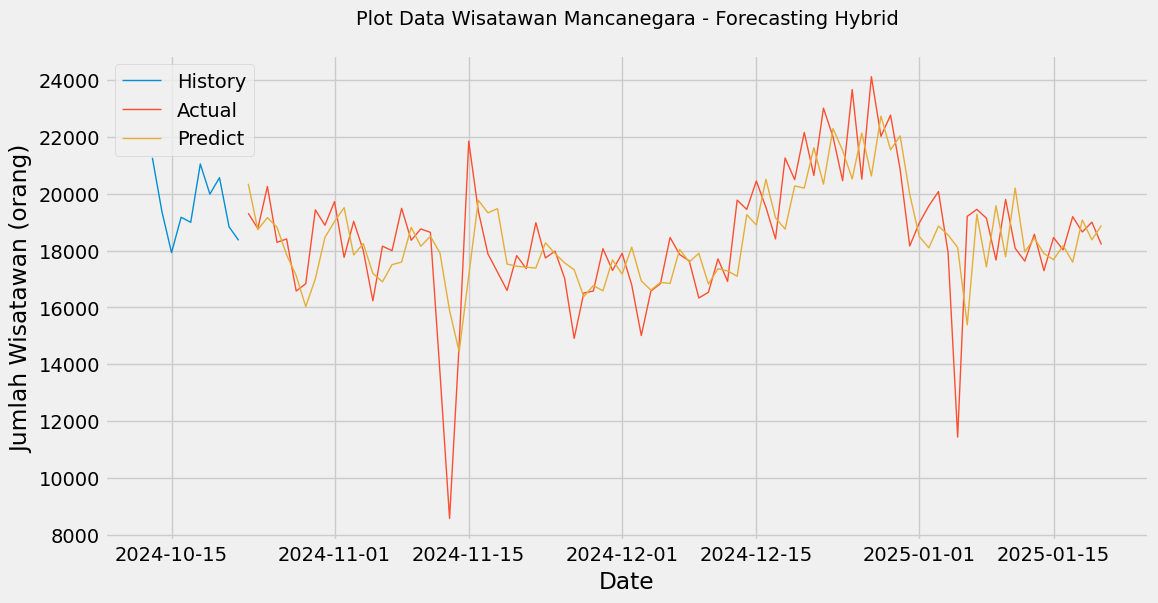

In [ ]:
# Plot Data
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_hybrid_final['Wisman Bali'], linewidth=1, label='Actual')
plt.plot(df_hybrid_final['Hybrid Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (orang)')
plt.title('Plot Data Wisatawan Mancanegara - Forecasting Hybrid\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
